In [1]:
# Notebook to generate images

# The last two are kept for normalization purposes.
import pandas as pd
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pickle
from xgboost import XGBClassifier


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from general.data_generation import graph_to_df, draw_fa2, draw_kk
from general.model_utils import preprocess_data, make_predictions

from src.graph_dataset import GraphDataset
from src.graph_parser import parseGraphmlFile
from src.graph_utils import stress, total_stress, num_crossings, mean_edge_length, nodes_dict_to_array, distance_matrix
from src.graph_utils import gradient_kamada_kawai, max_neighbour_degrees_norm, sum_neighbour_degrees_norm, expansion_factor_norm, edge_crossings_norm
from src.graph_utils import max_j_node_centrality, sum_j_node_centrality, j_node_centrality, graph_entropy_norm, electro_forces_in_neighbourhood, cos_force_diff_in_neighbourhood

No cython detected.  Install cython and compile the fa2util module for a 10-100x speed boost.


In [8]:
#####
# Auxiliary functions 
#####
def bfs_on_edges(g: nx.Graph, edge: list or tuple, depth_limit) -> list:
    bfs_edges = {edge}
    sp = dict(nx.all_pairs_shortest_path_length(g))
    for e in nx.edge_bfs(g, edge[0]):
        if sp[e[0]][edge[0]] == depth_limit+1 or sp[e[1]][edge[0]] == depth_limit+1:
            break
        bfs_edges.add(e)
    
    for e in nx.edge_bfs(g, edge[1]):
        if sp[e[0]][edge[1]] == depth_limit+1 or sp[e[1]][edge[1]] == depth_limit+1:
            break
        bfs_edges.add(e)

    return list(bfs_edges)

def relax_block(graph: nx.Graph, draw_f, model: XGBClassifier, data: pd.DataFrame = None, depth_limit: int = 3, num_it = 5) -> dict:
    """Relax 1 edge -> block near edges -> relax 1 edge -> block near edges -> ... 
    
    Args:
        graph (nx.Graph): graph to relax
        draw_f (function): function to draw the graph
        model (XGBClassifier): model to use for predictions on which edge to relax
        data (pd.DataFrame): data to use for predictions. If None, it will be computed from the graph
        depth_limit (int): number of bfs steps to block. Default is 3.

    Returns:
        pos (dict): final positions of the nodes
    """
    if data is None:
        data = graph_to_df(graph,0,draw_f,bench='Test', include_labels=False)
        X = preprocess_data(data,return_labels=False,drop_labels=False)
    else:
        X = preprocess_data(data,return_labels=False,drop_labels=True)
    proba = np.array(make_predictions(model, X)).flatten()

    diff_crossings = -1
    relaxed_edges = []
    diff_crossings_hist = []

    g2 = graph.copy()

    edge2idx = {e:idx for idx, e in enumerate(graph.edges)}
    for idx, e in enumerate(graph.edges):
        edge2idx[e[::-1]] = idx

    # print(np.max(list(edge2idx.values())))
    # print(len(proba))

    for it in range(num_it):
        max_proba_idx = np.argmax(proba)
        max_proba_edge = list(graph.edges)[max_proba_idx]
        relaxed_edges.append(max_proba_edge)
        
        edges2block = bfs_on_edges(graph, max_proba_edge, depth_limit)
        idxedges2block = [edge2idx[e] for e in edges2block]

        for e in [max_proba_idx, *idxedges2block]:
            proba[e] = -1

        g2.remove_edges_from([max_proba_edge])

        diff_crossings = compareGraphs(graph, graph, draw_f(graph), draw_f(g2), show=False)[0]
        diff_crossings_hist.append(diff_crossings)
    
    min_crossings_idx = np.argmin(diff_crossings_hist)

    g2 = graph.copy()

    g2.remove_edges_from(relaxed_edges[:min_crossings_idx])

    pos = draw_f(g2, pos=draw_f(graph))

    return pos

def relax_and_recompute(graph: nx.Graph, draw_f, model: XGBClassifier, data: pd.DataFrame = None, T:float = 0. , k: int = 3) -> dict:
    """Relax 1 edge -> recompute -> relax 1 edge -> recompute -> ... k times
    
    Args:
        graph (nx.Graph): graph to relax
        draw_f (function): function to draw the graph
        model (XGBClassifier): model to use for predictions on which edge to relax
        data (pd.DataFrame): data to use for predictions. If None, it will be computed from the graph
        k (int): number of times we execute the procedure. Default is 3.

    Returns:
        pos (dict): final positions of the nodes
    """
    if data is None:
        data = graph_to_df(graph,0,draw_f,bench='Test', include_labels=False)
        X = preprocess_data(data,return_labels=False,drop_labels=False)
    else:
        X = preprocess_data(data,return_labels=False,drop_labels=True)

    proba = make_predictions(model,X)

    removed_edges = []
    pos0 = draw_f(graph)
    pos1 = pos0
    for i in range(k):
        print(f'Iteration {i+1}/{k}')
        max_proba_idx = np.argmax(proba)
        if proba[max_proba_idx] < T:
            print('No more edges to remove')
            break
        max_proba_edge = list(graph.edges)[max_proba_idx]
        removed_edges.append(max_proba_edge)

        g2 = graph.copy()
        # g2.remove_edges_from([max_proba_edge])
        g2.remove_edges_from(removed_edges)

        pos1 = draw_f(g2,pos=pos1)

        data = graph_to_df(g2,0,draw_f,bench='Test',include_labels=False)
        
        if data is None:
            proba[max_proba_idx] = -1
            removed_edges.pop()
            # To ensure that we don't remove the same edge twice
            # And that we keep the edge that gave an error on removal
            # Results are worse this way for now
            continue

        data = data.fillna(data.mean(numeric_only=True))

        X = preprocess_data(data,return_labels=False,drop_labels=False)
        proba = make_predictions(model,X)
    
    return pos1


with open('../data/idToGraph.pickle', 'rb') as f:
    graphid2src = pickle.load(f)

In [11]:
from src.graph_utils import compareGraphs

method2function = {
    "kk": draw_kk,
    "fa2": draw_fa2
}

def image_before_after_relaxation(graph_id: int, model_name: str = "xgb", draw_method: str = "fa2", relax_f = relax_and_recompute):
    g = graphid2src[0]
    model = XGBClassifier()
    model.load_model(f'../data/{model_name}_{draw_method}.bin')
    orig_pos = method2function[draw_method](g)
    pos = relax_f(g, draw_f=method2function[draw_method], model=model)
    compareGraphs(g, g, orig_pos, pos, titles=['before relaxation', 'after relaxation'])
    
def image_relaxation_types(graph_id: int, model_name: str = "xgb", draw_method: str = "fa2"):
    g = graphid2src[graph_id]
    model = XGBClassifier()
    model.load_model(f'../data/{model_name}_{draw_method}.bin')
    orig_pos = method2function[draw_method](g)
    orig_crossings = num_crossings(g, orig_pos)
    pos1 = relax_and_recompute(g, draw_f=method2function[draw_method], model=model)
    pos1_crossings = num_crossings(g, pos1)
    pos2 = relax_block(g, draw_f=method2function[draw_method], model=model)
    pos2_crossings = num_crossings(g, pos1)
    plt.subplot(131, aspect=1)
    plt.title(f"Original ({orig_crossings})")
    nx.draw(g, pos=orig_pos, node_size=10)
    plt.subplot(132, aspect=1)
    plt.title(f"Relax and recompute ({pos1_crossings})")
    nx.draw(g, pos=pos1, node_size=10)
    plt.subplot(133, aspect=1)
    plt.title(f"Relax and block ({pos2_crossings})")
    nx.draw(g, pos=pos2, node_size=10)

Iteration 1/3


/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:793: RuntimeWarning: divide by zero encountered in log
  return -np.sum([degree[node]/(2*nEdges)*np.log(degree[node]/(2*nEdges)) for node in G.nodes])/np.log(nNodes)
/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:793: RuntimeWarning: invalid value encountered in scalar multiply
  return -np.sum([degree[node]/(2*nEdges)*np.log(degree[node]/(2*nEdges)) for node in G.nodes])/np.log(nNodes)


Iteration 2/3
Iteration 3/3


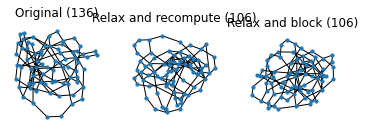

In [12]:
image_relaxation_types(1)

In [5]:
!python3.9 -m pip install --upgrade scipy

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
